In [ ]:
# Importing libraries needed.
import os
import random
import glob
import base64
import io
import collections
from collections import deque, namedtuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
from gym.wrappers.monitoring import video_recorder

from IPython.display import HTML
from IPython import display
from base64 import b64encode




In [ ]:
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
#Initializing the environment.
env = gym.make('LunarLander-v3')

# Setting the seed for reproducibility.
state, info = env.reset(seed=0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)



State shape:  (8,)
Number of actions:  4


In [ ]:
#Defining Neural Network Architecture.
class QNetwork(nn.Module):
    """DQN that gives the action-value function."""

    def __init__(self, state_size, action_size, seed):
        """Initializing parameters and building the model.
        Parameters:
            state_size: Dimension of each state
            action_size: Dimension of each action
            seed: Random seed.
        """
        super(QNetwork, self).__init__() # Initialising parent class.
        self.seed = torch.manual_seed(seed)
        # Defining layers in neural network.
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Building a network that maps state to action values.
        Parameters:
            State: current state
        Returns:
            Q-values
        """
        x = self.fc1(state) # Linear transformation.
        x = F.relu(x) # ReLU activation.
        x = self.fc2(x) # Linear transformation.
        x = F.relu(x) # ReLU activation.
        return self.fc3(x) # return q-value for all actions.

In [ ]:
#Defining the hyperparameter
BUFFER_SIZE = int(1e5)  # setting replay buffer size.
BATCH_SIZE = 64         # setting minibatch size.
GAMMA = 0.99            # setting discount factor.
TAU = 1e-3              # setting for soft update of target parameters.
LR = 5e-4               # setting learning rate.
UPDATE_EVERY = 4        # setting how often to update the network.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   # Select the device to run the model on: GPU if available, otherwise fallback to CPU.

In [ ]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initializes an Agent object.

        Parameters:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory - store past experiences.
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """
        Save experience and learn after every action.

        Parameters:
            state: current state of the environment
            action: action taken by the agent
            reward: reward received after the action
            next_state: resulting state after the action
            done: whether the episode has ended

        Returns:
            loss
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Initialize loss to None
        loss = None

        # Learn every UPDATE_EVERY steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences, GAMMA)

        return loss

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Parameters:
            state: current state
            eps: epsilon, for epsilon-greedy action selection

        Returns:
            int: selected action
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())  # exploit
        else:
            return random.choice(np.arange(self.action_size))   # explore

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

         Parameters:
            experiences: tuple of (s, a, r, s', done) tuples
            gamma: discount factor

        Returns:
            float: loss value
        """
        states, actions, rewards, next_states, dones = experiences

        # Compute Q targets for current states
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        # Get expected Q values from local model
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        return loss.item()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters using this formula:
        θ_target = τ*θ_local + (1 - τ)*θ_target

         Parameters:
            local_model: weights will be copied from
            target_model: weights will be copied to
            tau: interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [ ]:
#Define Replay buffer
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

         Parameters:
            action_size: dimension of each action
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
            seed: random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory.

         Parameters:
            state: state of the environment
            action: action taken
            reward: reward given after action
            next_state: state of the env after actiont taken
            done: boolean, whether the episode has ended.
        """

        # Create tuple for the experience and add it to the memory.
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""

        # Random sample from memory.
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        # Return tuple of components.
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
# Your dqn() function, updated to log loss values:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning: training.

    Parameters:
        n_episodes: maximum number of training episodes
        max_t: maximum number of timesteps per episode
        eps_start: starting value of epsilon, for epsilon-greedy action selection
        eps_end: minimum value of epsilon
        eps_decay: multiplicative factor (per episode) for decreasing epsilon

    Returns:
        scores: reward per episode
        loss history: average loss per episode.
    """
    scores = []                        # list containing scores from each episode.
    scores_window = deque(maxlen=100)  # last 100 scores.
    loss_history = []                  # list to store average training loss per episode.
    eps = eps_start                    # initialize epsilon.

    for i_episode in range(1, n_episodes+1):
        # Reset the environment and unpack the state only.
        state, _ = env.reset()
        score = 0
        episode_losses = []

        for t in range(max_t):
            # select action using e-greedy.
            action = agent.act(state, eps)
            next_state, reward, done, truncated, _ = env.step(action)

            # Store experience and learn.
            loss = agent.step(state, action, reward, next_state, done)
            # Save loss score.
            if loss is not None:
                episode_losses.append(loss)

            # Move to next state and accumulate reward.
            state = next_state
            score += reward
            if done or truncated:
                break

        scores_window.append(score)       # save most recent score.
        scores.append(score)              # save total score for this episode.

        # Compute the average loss for this episode (if any updates occurred).
        if episode_losses:
            avg_loss = np.mean(episode_losses)
        else:
            avg_loss = 0
        loss_history.append(avg_loss)

        eps = max(eps_end, eps_decay * eps) # decrease epsilon.

        # Print progress.
        print('\rEpisode {}\tAverage Score: {:.2f}\tAvg Loss: {:.4f}'.format(
            i_episode, np.mean(scores_window), avg_loss), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAvg Loss: {:.4f}'.format(
                i_episode, np.mean(scores_window), avg_loss))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode - 100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    # Return scores and loss history.
    return scores, loss_history

# Assuming Agent class have already been defined, environment (env), and our agent object:
agent = Agent(state_size=8, action_size=4, seed=0)
scores, loss_history = dqn()

Episode 100	Average Score: -156.22	Avg Loss: 49.2936
Episode 200	Average Score: -110.33	Avg Loss: 23.6572
Episode 300	Average Score: -37.22	Avg Loss: 10.2853
Episode 400	Average Score: -28.93	Avg Loss: 0.8996
Episode 500	Average Score: 77.08	Avg Loss: 5.7720
Episode 600	Average Score: 197.40	Avg Loss: 10.4808
Episode 603	Average Score: 200.37	Avg Loss: 10.3785
Environment solved in 503 episodes!	Average Score: 200.37


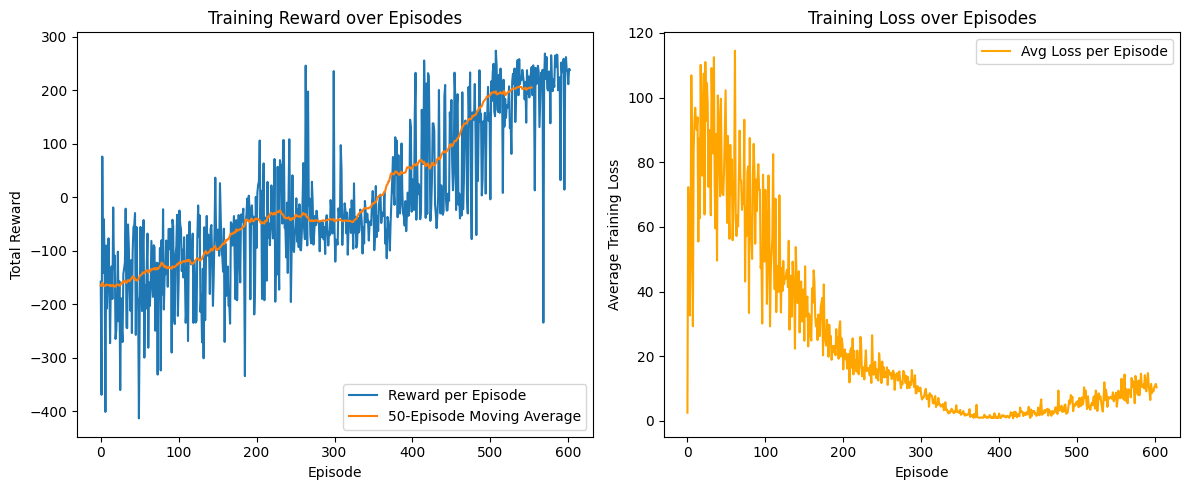

In [ ]:
# Plotting the Reward vs. Episode Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(scores, label="Reward per Episode")
plt.plot(np.convolve(scores, np.ones(50)/50, mode='valid'),
         label="50-Episode Moving Average")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward over Episodes")
plt.legend()

# Plotting the Average Training Loss vs. Episode Graph
plt.subplot(1, 2, 2)
plt.plot(loss_history, color="orange", label="Avg Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Training Loss")
plt.title("Training Loss over Episodes")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def show_video_of_model(agent, env_name):
    """
    Runs agent in the environment and records a video.

    Parameters:
        agent: Trained agent with an 'act' method.
        env_name: Name of the OpenAI Gym environment.

    Returns:
        HTML: Video of the game for display in Jupyter Notebook.
    """

    # Create the 'video' directory if it doesn't exist.
    if not os.path.exists('video'):
        os.makedirs('video')

    # Create the environment with render_mode='rgb_array'
    env = gym.make(env_name, render_mode='rgb_array')

    # Set up the output video recorder
    video_path = f"video/{env_name}.mp4"
    vid = video_recorder.VideoRecorder(env, path=video_path)

    # Load the model parameters
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location=torch.device('cpu')))
    agent.qnetwork_local.eval()

    # Reset environment
    state, _ = env.reset()
    done = False

    while not done:
        frame = env.render()
        vid.capture_frame()
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    vid.close()
    env.close()

    # Encode video to base64 for display in notebook
    with open(video_path, "rb") as f:
        video_data = f.read()
    encoded = b64encode(video_data).decode('utf-8')

    return HTML(f"""
    <video width="480" controls>
        <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
    </video>
    """)

#Example usage in a notebook (after defining agent and saving checkpoint):
show_video_of_model(agent, 'LunarLander-v3')


/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
